# Word2Vec e predizione prossima parola - Lorenzo Busin
Il Natural Language Processing (NLP) è il processo di elaborazione del linguaggio naturale e di comprensione di un testo scritto o del parlato in modo simile a come viene compreso dagli umani. Per linguaggio naturale si intende la lingua che usiamo nella vita di tutti i giorni, ad esempio l’italiano o l'inglese, ed è sinonimo di linguaggio umano, distinguendolo quindi da un linguaggio formale. Rispetto ad un linguaggio formale, esso è molto più complesso, contiene spesso sottointesi e ambiguità, il che lo rende molto difficile da elaborare. Sono diverse le applicazioni del NLP, tra queste vi si può trovare: controllo ortografico, classificazione del testo, traduzione automatica, risposta automatica a domande e predizione di parole.


L'idea alla base di questo progetto didattico è quella di provare a prevedere quale sarà la parola successiva in un meccanismo simile a quello che è possibile trovare nelle keyboards degli smartphone, suggerendo all'utente tre possibili parole adatte per la continuazione della frase.

In [ ]:
%matplotlib inline
import collections
import math
import numpy as np
import random
import time
from matplotlib import pylab
from six.moves import range
from sklearn.decomposition import PCA

from nltk.tokenize import RegexpTokenizer
from keras.models import Sequential, load_model
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.layers.core import Dense, Activation
from gensim.models import Word2Vec

import warnings
warnings.filterwarnings("ignore")

## Dataset
Per svolgere un task di apprendimento automatico è molto importante la scelta del set di dati. Il dataset impiegato per questo progetto consiste di un corpus di un milione e mezzo di parole che fa parte di un dataset più grande in cui sono presenti numerose notizie. Qualunque dataset contenente del testo scritto può essere utilizzato per questo task ma per ottenere buone performarce è importante che esso sia molto ampio in modo apprendere al meglio il significato delle parole anche in diversi contesti.


In [ ]:
input_file = open('news.txt', encoding="utf8").read().lower() # open the input file

input_file = input_file.split()
input_text = input_file[0:1500000] # take the first 1500000 words
corpus_length = len(input_text)
word_frequency = collections.Counter(input_text).most_common(10000) # compute the frequency of each word

print("Word frequency")
print(word_frequency)
print("\nCorpus length: ", corpus_length)

Word frequency
[('the', 84496), ('to', 38964), ('and', 38253), ('a', 37430), ('of', 33527), ('in', 28814), ('for', 15132), ('that', 14234), ('is', 12229), ('on', 11398), ('with', 11012), ('was', 9895), ('he', 9609), ('at', 9155), ('as', 8143), ('it', 7767), ('his', 6738), ('from', 6518), ('be', 6466), ('but', 6279), ('have', 6055), ('said', 6044), ('are', 5970), ('by', 5816), ('an', 5325), ('has', 5266), ('i', 5074), ('will', 4747), ('this', 4744), ('who', 4701), ('they', 4683), ('not', 4650), ('or', 4153), ('said.', 3958), ('about', 3830), ('their', 3804), ('you', 3673), ('more', 3545), ('had', 3487), ('one', 3313), ('when', 3193), ('she', 3188), ('were', 3183), ('we', 3175), ('would', 3117), ('new', 2937), ('been', 2912), ('her', 2885), ('up', 2882), ('out', 2663), ('all', 2607), ('if', 2598), ('which', 2568), ('after', 2567), ('its', 2523), ('than', 2520), ('also', 2511), ('two', 2437), ('can', 2402), ('--', 2380), ('just', 2310), ('last', 2229), ('what', 2222), ('so', 2193), ('some

## Preprocessing
Un'operazione essenziale è il preprocessing dei dati, infatti impiegare un dataset "grezzo" per effettuare l'apprendimento potrebbe risultare non molto efficace. All'interno di un testo o più comunemente anche nella lingua parlata ci sono parole  che vengono utilizzate in minore o maggiore frequenza rispetto ad altre che sono di uso più o meno comune. Parole che vengono usate molto raramente non sono utili da apprendere in quanto poco significative, anche perchè difficilmente saranno usate.

Allo stesso modo ci sono invece parole che vengono utilizzate più frequententemente, basti pensare ad articoli, avverbi e preposizioni, e ciò può sbilanciare il processo di apprendimento rendendo queste parole fin troppo significative. Quando si effettua l'analisi del dataset testuale è importante conoscere la frequenza con cui ogni singola parola è presente all'interno del corpus. Per rendere più uniforme la distribuzione ed ottenere dei risultati migliori è stata impiegata una tecnica nota come *subsampling di Mikolov* (link al paper https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf). Si tratta di un metodo per filtrare parole molto frequenti. L'idea alla base è simile alla rimozione delle *stopwords*, cioè quelle parti del discorso che non contribuiscono in modo significativo all'esprimere un concetto. Questa tecnica, invece, si basa sull'eliminazione delle parole che hanno una frequenza superiore ad una certa soglia *t* con probabilità p=1-$\sqrt{\frac{t}{f}}$, dove *f* indica la frequenza della parola all'interno del corpus. Tramite il subsampling è quindi possibile rendere più uniforme la distribuzione delle parole senza doverle eliminare del tutto: infatti per un predittore potrebbe essere utile suggerire all'utente parole come ad esempio articoli, avverbi o preposizioni per la costruzione di una frase.
Le parole che presentano una frequenza minore rispetto alla soglia *min_freq* vengono direttemente eliminate dal corpus.

Il subsampling presenta due vantaggi: ottenere un corpus con parole più significative e con una distribuzione più uniforme, ed allo stesso tempo ridurne la dimensione, rendendo più efficace ed efficiente l'apprendimento.


In [ ]:
t = 10**(-3) # threshold value
min_freq = 25 / corpus_length # minumum frequency of each word

wf = dict() # contains the probability of deletion for each word
for w, n in word_frequency:
  f = n / corpus_length # compute the frequency of each word (number of occurrences / corpus length)
  if f > t:
    p = 1 - math.sqrt(t/f) # compute the probability of deletion of the word
  elif f < min_freq:
    p = 1 # if the frequency is < than min_freq delete the word
  else:
    p = 0
  wf[w] = p # prob to delete w

print("Probability of deletion\n",wf)

text = []
for w in input_text:
  if w in wf:
    p = wf[w]
    if (random.choices([1, 0], [1-p, p], k=1)) == [1]: # Mikolov's subsampling
      text.append(w)


print("\nWord frequency after subsampling \n",collections.Counter(text).most_common(10000))
print("\nCorpus length after subsampling: ", len(text))

Probability of deletion
 {'the': 0.8667621688992481, 'to': 0.8037932870099519, 'and': 0.8019782568109617, 'a': 0.7998130715928164, 'of': 0.7884815368580137, 'in': 0.7718377170787927, 'for': 0.6851545197287023, 'that': 0.6753748608609014, 'is': 0.649772570182906, 'on': 0.6372300516238771, 'with': 0.6309267848512836, 'was': 0.6106521953492523, 'he': 0.6049004520054773, 'at': 0.5952224147747072, 'as': 0.5708062272016676, 'it': 0.5605403788810037, 'his': 0.5281758934376152, 'from': 0.5202793080201844, 'be': 0.5183541979559434, 'but': 0.5112346746756995, 'have': 0.5022760308531912, 'said': 0.5018233112275652, 'are': 0.49874529288291447, 'by': 0.4921523693508224, 'an': 0.46925510756572475, 'has': 0.4662901696041687, 'i': 0.45628614727410277, 'will': 0.4378709705831926, 'this': 0.43769325973115825, 'who': 0.43512740676694817, 'they': 0.4340428503893713, 'not': 0.4320381657529352, 'or': 0.39901357272453863, 'said.': 0.38438706765866926, 'about': 0.3741846050022515, 'their': 0.3720495508708397,

## Word2Vec
Per codificare le parole è stato usato Word2Vec, cioè un modello di apprendimento non supervisionato per la costruzione dei word embeddings, il cui algoritmo richiede in ingresso un corpus e restituisce un insieme di vettori parola di dimensione predefinita, che rappresentano la distribuzione semantica delle parole nel testo. Per ogni parola presente, in modo univoco, viene costruito un vettore denso in modo da rappresentarla come un punto nello spazio multidimensionale. In questo spazio le parole saranno più vicine se riconosciute come semanticamente più simili e viceversa. Una volta effettuato il preprocessing del dataset, viene rimossa la punteggiatura dal testo e vengono
costruite delle *sentences* costituite da 50 parole ciascuna che saranno poi passate in ingresso al modello Word2Vec per la costruzione dei word embeddings.

La dimensione dei periodi è prefissata: la soluzione ottimale sarebbe quella di costruire frasi coerenti semanticamente con il reale significato del testo ma ciò non è sempre possibile. Per rendere questo progetto funzionante con qualunque tipo di dataset testuale si è optato per questa scelta.

In [ ]:
n = 50 # sentence length
text = [' '.join(text[i:i+n]) for i in range(0,len(text),n)]
print('Number of sentences:', len(text))

tokenizer = RegexpTokenizer("[\w']+") # remove punctuaction
text_splits = []
for s in text:
  text_splits.append(tokenizer.tokenize(s)) # build the senteces

print(text_splits[0])

Number of sentences: 16519
["wasn't", 'home', 'st', 'louis', 'plant', 'had', 'close', 'would', 'die', 'old', 'age', 'workers', 'been', 'making', 'cars', 'there', 'since', 'mass', 'production', 'plans', 'quickly', 'became', 'a', 'hot', 'local', 'online', 'though', 'most', 'people', 'plans', 'new', 'center', 'many', 'potential', 'loss', 'the', 'building', 'group', 'of', 'mount', 'up', 'for', 'contract', 'last', 'fall', 'suggest', 'improvements', 'trenton', 'water', 'works']


## Tuning degli iperparametri
Il modello Word2Vec usato fa parte della libreria gensim e dispone di diversi iperparametri, infatti, è importante selezionare il modello migliore in base alle sue prestazioni. Per fare ciò è stata impiegata una tecnica simile alla K-fold Cross Validation: data una lista di diversi iperparametri vengono calcolate ed analizzate le prestazioni ottenute dai vari modelli, estraendo in modo randomico un insieme di campionionamento da usare come input. 

Per la valutazione è stato usato il metodo *evaluate_word_pairs* che confronta la correlazione del modello con dei valori di similarità espressi dagli umani (il dataset di test è disponibile al seguente link http://www.gabrilovich.com/resources/data/wordsim353/wordsim353.html). 

Le metriche con cui i modelli sono stati valutati sono:
- Indice di correlazione di Pearson: date due variabili statistiche è un indice che esprime un'eventuale relazione di linearità tra esse;
- Indice di correlazione per ranghi di Spearman: è una misura statistica non parametrica di correlazione che misura il grado di relazione tra due variabili con l'ipotesi che esse siano ordinabili. Permette di stabilire quanto bene una relazione tra due variabili possa essere descritta usando una funzione monotona. Questa metrica viene calcolata tramite il confronto della similarità di una coppia di parole presente nel dataset di test con quella prodotta dal modello stesso;
- Tempo di esecuzione.

In [ ]:
data_test = open('wordsim353.txt', encoding="utf8").read().lower() # test set to evaluate the Word2Vec model
print(data_test[:500])

# the wordsimilarity-353 test collection 
# word 1	word 2	human (mean)
love	sex	6.77
tiger	cat	7.35
tiger	tiger	10.00
book	paper	7.46
computer	keyboard	7.62
computer	internet	7.58
plane	car	5.77
train	car	6.31
telephone	communication	7.50
television	radio	6.77
media	radio	7.42
drug	abuse	6.85
bread	butter	6.19
cucumber	potato	5.92
doctor	nurse	7.00
professor	doctor	6.62
student	professor	6.81
smart	student	4.62
smart	stupid	5.81
company	stock	7.08
stock	market	8.08
stock	phone	1.62
stock	cd	1.31


## Modello Skip-gram
Word2Vec può utilizzare due diverse tecniche di unsupervised learning: Skip-gram e CBOW.

Il focus del modello Skip-gram è quello di provare a predire il contesto di riferimento a partire da una parola target. Considerando una finestra di 5 parole, data in input la parola target in posizione *t* w(t), Skip-gram
prova ad predire le parole w(t-2), w(t-1), w(t+1) e (t+2), cioè quelle parole che costituiscono il contesto della parola target.

In [ ]:
size = [16, 32, 64] # dimensionality of word embeddings
max_iter = [10, 20, 50] # number of iterations

print("Skip-gram model scores")
for s in size:
  for i in max_iter:
    test_sample = random.sample(text_splits, 5000) 
    start = time.time()
    test_model = Word2Vec(test_sample, size=s, iter=i, sg=1)
    Word2Vec()
    print("Model with size={}".format(s) + " and n_iter={}".format(i))
    time_spent = time.time() - start
    pearson_sg , spearman_sg, _= test_model.wv.evaluate_word_pairs(pairs='wordsim353.txt')
    print("Pearson: \t{}".format('%.2f'% pearson_sg[0]))
    print("Spearman: \t{}".format('%.2f'% spearman_sg[0]))
    print("Time spent: \t{} s".format('%.2f'% time_spent))
    print()


Skip-gram model scores
Model with size=16 and n_iter=10
Pearson: 	0.40
Spearman: 	0.36
Time spent: 	11.92 s

Model with size=16 and n_iter=20
Pearson: 	0.48
Spearman: 	0.48
Time spent: 	23.15 s

Model with size=16 and n_iter=50
Pearson: 	0.37
Spearman: 	0.37
Time spent: 	55.00 s

Model with size=32 and n_iter=10
Pearson: 	0.42
Spearman: 	0.40
Time spent: 	9.79 s

Model with size=32 and n_iter=20
Pearson: 	0.48
Spearman: 	0.48
Time spent: 	18.52 s

Model with size=32 and n_iter=50
Pearson: 	0.44
Spearman: 	0.46
Time spent: 	45.08 s

Model with size=64 and n_iter=10
Pearson: 	0.37
Spearman: 	0.37
Time spent: 	11.44 s

Model with size=64 and n_iter=20
Pearson: 	0.44
Spearman: 	0.43
Time spent: 	22.13 s

Model with size=64 and n_iter=50
Pearson: 	0.41
Spearman: 	0.41
Time spent: 	53.32 s



## Modello CBOW
Il focus del modello Continuous-Bag-of-Words è quello di provare a predire una parola target a partire dalle parole che costituiscono il suo contesto. Considerando sempre una finestra di dimensione 5, date in input le parole w(t-2), w(t-1), w(t+1) e (t+2), queste vengono combinate per ottenere la parola target w(t).

In [ ]:
print("CBOW model scores")
for s in size:
  for i in max_iter:
    test_sample = random.sample(text_splits, 5000)
    start = time.time()
    test_model = Word2Vec(test_sample, size=s, iter=i)
    print("Model with size={}".format(s) + " and n_iter={}".format(i))
    time_spent = time.time() - start
    pearson_cbow , spearman_cbow, _ = test_model.wv.evaluate_word_pairs(pairs='wordsim353.txt')
    print("Pearson: \t{}".format('%.2f'% pearson_cbow[0]))
    print("Spearman: \t{}".format('%.2f'% spearman_cbow[0]))
    print("Time spent: \t{} s".format('%.2f'% time_spent))
    print()

CBOW model scores
Model with size=16 and n_iter=10
Pearson: 	0.16
Spearman: 	0.17
Time spent: 	4.71 s

Model with size=16 and n_iter=20
Pearson: 	0.42
Spearman: 	0.40
Time spent: 	8.20 s

Model with size=16 and n_iter=50
Pearson: 	0.42
Spearman: 	0.41
Time spent: 	19.44 s

Model with size=32 and n_iter=10
Pearson: 	0.08
Spearman: 	0.14
Time spent: 	4.01 s

Model with size=32 and n_iter=20
Pearson: 	0.36
Spearman: 	0.34
Time spent: 	6.93 s

Model with size=32 and n_iter=50
Pearson: 	0.42
Spearman: 	0.41
Time spent: 	15.58 s

Model with size=64 and n_iter=10
Pearson: 	0.10
Spearman: 	0.14
Time spent: 	4.39 s

Model with size=64 and n_iter=20
Pearson: 	0.34
Spearman: 	0.31
Time spent: 	7.63 s

Model with size=64 and n_iter=50
Pearson: 	0.43
Spearman: 	0.43
Time spent: 	18.14 s



## Confronto dei risultati ottenuti
Per confrontare i risultati ottenuti c'è da tenere in considerazione che i valori calcolati possono dipendere, in parte, dalla casualità con cui viene estratto l'insieme di campionamento.

Osservando questi risultati si può notare come in generale il modello skip-gram permetta di ottenere delle performance migliori a discapito dell'efficienza; CBOW invece permette di ottenere delle discrete performance però in tempi più ragionevoli. In conclusione, se il dataset non è molto grande è da preferire il modello Skip-gram, altrimenti è preferibile adottare il modello CBOW.

## Embeddings Learning
Una volta trovati i parametri ottimali, vengono costruiti i word embeddings tramite il modello Word2Vec. Contestualmente vengono costruiti due dizionari: *index2word* e *word2index*, che mappano ogni parola con il proprio indice univoco di riferimento e viceversa.

In [ ]:
word2vec_model = Word2Vec(text_splits, size=64, iter=50) # build Word2Vec model

final_embeddings = [] # list of word embeddings
index2word = dict()
word2index = dict()

for i, w in enumerate(word2vec_model.wv.vocab):
  index2word[i] = w
  word2index[w] = i
  final_embeddings.append(word2vec_model.wv[w])

vocab_size = len(index2word)
print("Words in vocabulary: ", vocab_size)

Words in vocabulary:  4649


## Visualizzazione delle parole nello spazio vettoriale
I vettori parola sono costituiti da *n* dimensioni e pertanto la loro rappresentazione grafica non è banale. Per ovviare a questa difficoltà, si può ricorrere ad una tecnica di riduzione della dimensionalità per trasformare i vettori da *n* a 2 dimensioni, in modo da parmetterne una facile rappresentazione all'interno di un grafico, considerando i due valori come coordinate del tipo (x, y). Per questo task è stata impiegata la PCA (Principal Component Analysis), cioè una tecnica di riduzione della dimensionalità che può essere utilizzata per estrarre informazioni da uno spazio ad alta dimensionalità proiettandolo in uno spazio di dimensione inferiore. Le variabili di output prendono il nome di componenti principali e sono ottenute attraverso combinazioni lineari delle variabili originali.

In [ ]:
num_points = 400 # take a sample of words
pca = PCA(n_components=2) # use PCA to reduce word embeddings dimension
two_d_embeddings = pca.fit_transform(final_embeddings) # reduce word embeddings into 2-dimensions

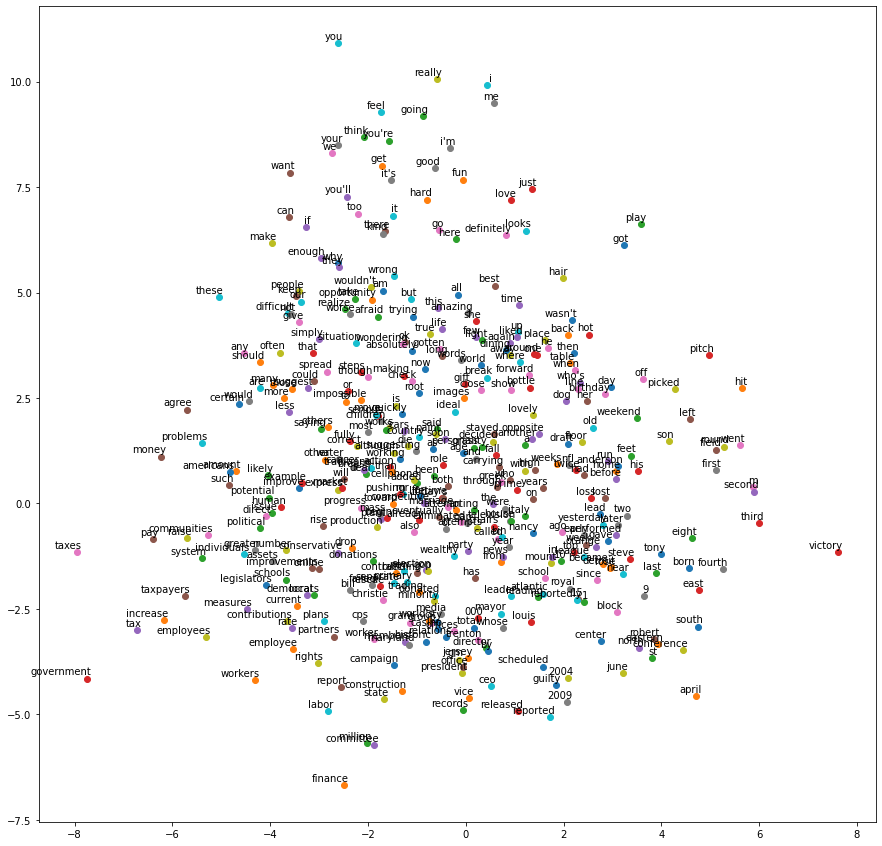

In [ ]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15, 15))
  for i, label in enumerate(labels):
    x, y = embeddings[word2index[label],:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
  pylab.show()

example_words = [index2word[i] for i in range(0, num_points)]
plot(two_d_embeddings, example_words)

Una volta che i vettori parola sono stati generati, invocando il metodo *most_similar()* è possibile osservare quali siano le parole più simili alla parola di input. Più le parole sono simili e più si trovano vicine nello spazio vettoriale, infatti per ottenere la parola più simile è sufficiente trovare quella che si trova più vicino. La metrica usata per il calcolo della distanza è la *cosine distance*.

Di seguito è possibile vedere alcuni esempi.

Similar words to december :  [('october', 0.7081799507141113), ('january', 0.6968560218811035), ('march', 0.680698573589325)]
Cosine distance between december and october :   0.29182
Cosine distance between december and january :   0.30314
Cosine distance between december and march :   0.31930

Similar words to food :  [('wine', 0.6400604844093323), ('italian', 0.6063923239707947), ('meal', 0.6044774651527405)]
Cosine distance between food and wine :   0.35994
Cosine distance between food and italian :   0.39361
Cosine distance between food and meal :   0.39552

Similar words to man :  [('woman', 0.7542725801467896), ('boy', 0.6670131683349609), ('girl', 0.6613166332244873)]
Cosine distance between man and woman :   0.24573
Cosine distance between man and boy :   0.33299
Cosine distance between man and girl :   0.33868



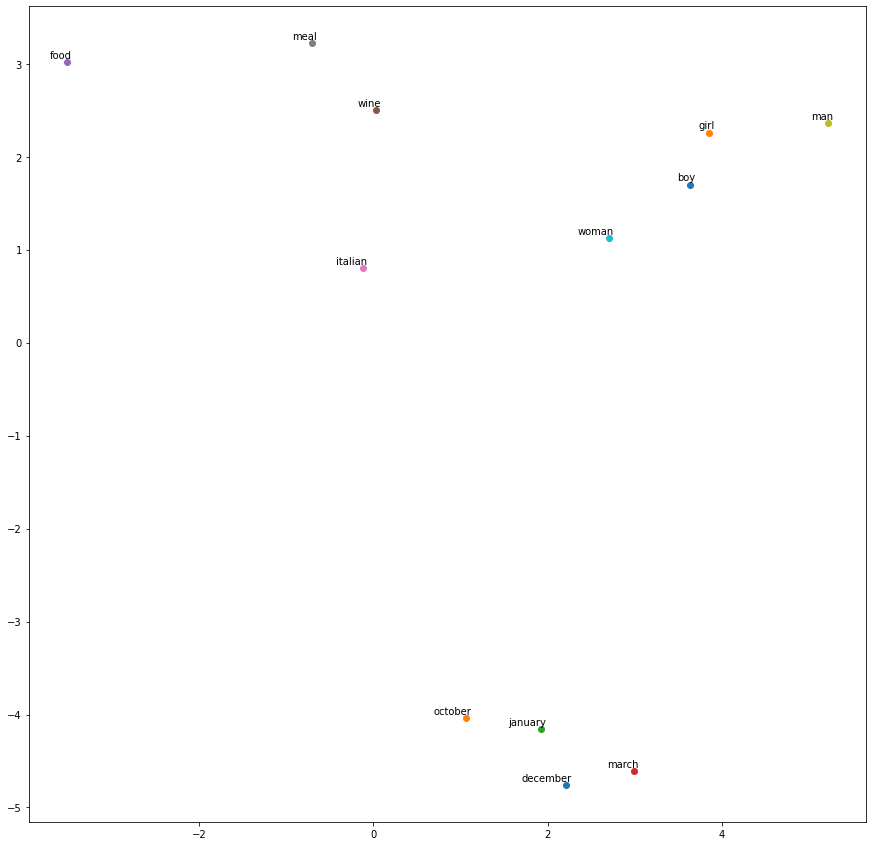

In [ ]:
test_words = ['december', 'food', 'man']
example_words = []

for t in test_words:
  example_words.append(t)
  similar = word2vec_model.wv.most_similar([t], topn=3) # topn similar words
  print("Similar words to",t,": ", similar)
  for s in similar:
    print("Cosine distance between",t,"and",s[0],":   {}".format('%.5f'% word2vec_model.wv.distance(t, s[0]))) # print the cosine distance between words
    example_words.append(s[0])
  print()

plot(two_d_embeddings, example_words)

## Modello n-gram
N-gram è un modello statistico che basa la predizione della parola successiva all'interno di una frase sulle *n-1* parole precedenti. In questo progetto è stato usato il modello 6-gram, in cui la parola target è influenzata dalle 5 parole che la precedono. L'idea è quella di calcolare la probabilità condizionata di una parola w(t) date le sue *n-1* parole precedenti. 

Per facilitare l'operazione di apprendimento vengono sostituite tutte le parole presenti nel corpus con il proprio indice identificativo. Successivamente viene costruita la matrice *X_train* a due dimensioni, in cui le righe corrispondono ai gruppi di 5 parole e le colonne corrispondono alla singola parola all'interno del quintetto. Per ogni quintetto viene poi memorizzata la parola target, codificata come *one-hot vector*, in *y_train*. La codifica one-hot è stata implementata costruendo per ogni parola un vettore di lunghezza *vocab_size*, in cui ogni valore presente è 0 (False) e soltanto uno è 1 (True): l'indice in cui si trova il valore 1 si riferisce all'indice univoco di quella parola all'interno del vocabolario.

In [ ]:
coded_text = [] # corpus where words are replaced by their vocabulary index

for sentence in text_splits:
  for word in sentence:
    if word in word2index:
      coded_text.append(word2index[word])

words = coded_text

window_size = 5 # number of previous words that determines the next word - model 6-gram

X_train = np.zeros((len(words) - window_size, window_size), dtype=np.int16) # group of 5 words, represents each word with its index
y_train = np.zeros((len(words) - window_size, len(index2word)), dtype=bool) # target word for every group of 5 words, represents the next word with one hot encoding

for i in range(len(words) - window_size):
  for j in range(window_size):
    X_train[i, j] = words[i+j]
  y_train[i, words[i+window_size]] = 1

print(X_train.shape)
print(X_train[0])
print(y_train.shape)
print(y_train[0])

(825286, 5)
[0 1 2 3 4]
(825286, 4649)
[False False False ... False False False]


## Training dei dati
Il modello con cui effettuare il training è il modello Sequential della libreria Keras e si basa su una pila di layer in cui ognuno di essi ha un tensore in ingresso e produce un tensore in uscita.

Il primo layer del modello è un Embedding layer il cui scopo è quello di ricevere degli interi in ingresso, che corrispondono agli indici delle parole presenti nel dizionario, e trasformarli in vettori densi, ovvero in word embeddings. Avendo già costruito in precedenza i vettori parola tramite il modello Word2vec è possibile specificarne i relativi pesi tramite il parametro *weights*. Viene anche specificata la dimensione del vocabolario che corrisponde al numero di parole che questo strato riceve in ingresso, la dimensione dei word embeddings da produrre in uscita e la lunghezza delle sequenze di parole.

Il secondo layer è un LSTM (Long Short-Term Memory), cioè una variante delle Recurrent Neural Networks. Le RNN sono reti neurali in grado di apprendere dagli eventi precendenti: esse però non sono molto versatili in quanto presentano dei pesanti aggiornamenti dei pesi della rete neurale a casa dell'accumulo di errori durante il calcolo del gradiente. LSTM riesce ad ovviare a queste problematiche sfruttando un meccanismo a cancello e ciò lo rende molto performante per un task di predizione delle parole. Come unico parametro dello strato viene specificato l'argomento *units* che deve corrispondere alla dimensione dell'output, ovvero alla *embedding_size*.

Il terzo layer è un insieme di unità connesse, una per ogni parola presente nel vocabolario, il cui scopo è semplicemente quello di applicare la funzione di attivazione ai pesi di input producendone il risultato come output. La funzione di attivazione usata è *softmax*, in quanto produce come output degli intervalli di probabilità  basati sul numero occorrenze delle parole target data una sequenza di 5 parole precedenti ad essa. La predizione di una parola, infatti, può essere considerato un task di clasificazione multi-classe, dove le diverse classi sono le parole presenti nel vocabolario e con la funzione softmax vengono stimate le probabilità che un dato input appartenga ad ognuna delle classi, ovvero data una sequenza di 5 parole vengono stimate le probabilità che ogni parola ha di essere quella successiva.

Prima di procedere al training del modello è necessario configurare il suo processo di apprendimento specificando attraverso la funzione *compile()* la loss function, l'ottimizzatore e quali metriche usare.

Infine, con la funzione *fit()* si procede con l'allenamento del modello: l'apprendimento avviene suddividendo i dati in batch di dimensione *batch_size* e iterando sull'intero dataset per un determinato numero di epoche. Per ottenere dei risultati più precisi si può settare l'argomento *validation_split* per dividere automaticamente parte del training set in validation set, indicando la frazione di dati da riservare per fare validazione. Durante questa operazione verrà visualizzato in tempo reale il tempo mancante per completare l'epoca corrente, il valore della loss function ed il valore delle metriche selezionate.

In [ ]:
pretrained_weights = word2vec_model.wv.syn0 # save the weights obtained from Word2Vec
_, embedding_size = pretrained_weights.shape

model = Sequential() # initialize keras model
model.add(Embedding(vocab_size, embedding_size, input_length=window_size, weights=[pretrained_weights]))
model.add(LSTM(embedding_size))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, validation_split=0.05, batch_size=64, epochs=10)

Epoch 1/10
12251/12251 [==============================] - 223s 18ms/step - loss: 7.1185 - accuracy: 0.0330 - val_loss: 6.9130 - val_accuracy: 0.0467
Epoch 2/10
12251/12251 [==============================] - 222s 18ms/step - loss: 6.7889 - accuracy: 0.0501 - val_loss: 6.8011 - val_accuracy: 0.0534
Epoch 3/10
12251/12251 [==============================] - 224s 18ms/step - loss: 6.6502 - accuracy: 0.0571 - val_loss: 6.7622 - val_accuracy: 0.0582
Epoch 4/10
12251/12251 [==============================] - 222s 18ms/step - loss: 6.5647 - accuracy: 0.0607 - val_loss: 6.7483 - val_accuracy: 0.0600
Epoch 5/10
12251/12251 [==============================] - 221s 18ms/step - loss: 6.5050 - accuracy: 0.0633 - val_loss: 6.7456 - val_accuracy: 0.0604
Epoch 6/10
12251/12251 [==============================] - 223s 18ms/step - loss: 6.4596 - accuracy: 0.0650 - val_loss: 6.7496 - val_accuracy: 0.0627
Epoch 7/10
12251/12251 [==============================] - 220s 18ms/step - loss: 6.4240 - accuracy: 0.0665

## Valutazione del modello
Per valutare quanto bene funzioni il modello è possibile invocare la funzione *generate_next()* per provare a predire la parola successiva. La funzione richiede di specificare quale modello usare, il testo di input formato da 5 parole separate da uno spazio ed il numero di *candidate words* da predire. La predizione avviene attraverso la funzione *predict()* del modello, che data una sequenza di 5 parole in input produce un vettore di dimensione *vocab_size* che contiene la distribuzione delle probabilità tali per cui l'i-esimo valore indica la probabilità che la parola, codificata come one-hot vector, venga selezionata come parola successiva. In seguito vengono selezionati i *top_n* indici che contengono le probabilità maggiori e vengono visualizzate le 3 parole corrispondenti agli indici selezionati.

Per valutare l'accuratezza del modello è stata definita una metrica simile all'*accuracy*, in cui le previsioni vengono considerate corrette se la parola attesa è presente tra le 3 parole generate. Per il calcolo di questa metrica è stato usato un dataset di test, quindi diverso da quello usato per effettuare il training del modello.

In [ ]:
test_text = input_file[1500000:] # take few words for the test set
print("Test corpus length:", len(test_text))

test_corpus = [] # test set with indexes of words
for w in test_text:
  word = tokenizer.tokenize(w)
  if word != []:
    if word[0] in word2index:
      test_corpus.append(word2index[word[0]])

X_test = np.zeros((len(test_corpus) - window_size, window_size), dtype=np.int16) # group of 5 words, represents each word with its index
y_test = np.zeros((len(test_corpus) - window_size, len(index2word)), dtype=bool) # target word for every group of 5 words, represents the next word with one hot encoding
for i in range(len(test_corpus) - window_size):
  for j in range(window_size):
    X_test[i, j] = test_corpus[i+j]
  y_test[i, test_corpus[i+window_size]] = 1

print(X_test.shape)
print(y_test.shape)

In [ ]:
def generate_next(model, text, top_n):
  """
  :param model: specify which model to use
  :param text: input string of 5 words
  :param top_n: number of words to predict
  :return: input string and the top_n generated words
  """
  x = np.zeros((1, window_size), dtype=np.int16)
  for i, word in enumerate(text.lower().split()):
     if word in word2index:
        x[0, i] = word2index[word]
  prediction = model.predict(x) # predict the probabilities
  preds = (-prediction).argsort()[0, :top_n] # take the index of the top_n probabilities
  candidate_words = []
  for p in preds:
    candidate_words.append(index2word[p]) # top_n predicted words
  if index2word[x[0, window_size-1]] in candidate_words: # if the last word of the input string appears into the prediction, discard it and take a different word
    preds = (-prediction).argsort()[0, :top_n+1]
    candidate_words = []
    for p in preds:
      candidate_words.append(index2word[p])
    candidate_words.remove(index2word[x[0, window_size-1]])
  return (text, candidate_words)

def accuracy_metric(model, X_test, y_test):
  """
  :param model: specify which model to use
  :param X_test: list of 5 indexes of word
  :param y_test: list of target words
  :return: accuracy value
  """
  cont = 0
  for i, x in enumerate(X_test):
    candidate_words = get_next(model, x, 3) # get the candidate words
    target_word = index2word[np.argmax(y_test[i])]
    a = []
    for l in x:
      a.append(index2word[l])
    if target_word in candidate_words: # if the prediction is correct
      cont += 1
  return cont/len(y_test)

def get_next(model, x, top_n):
  """
  :param model: specify which model to use
  :param x: input 5 indexes of word
  :param top_n: number of words to predict
  :return: top_n candidate words
  """
  text = np.zeros((1, window_size), dtype=np.int16)
  for i, w in enumerate(x):
    text[0, i] = w
  prediction = model.predict(text) # predict the probabilities
  preds = (-prediction).argsort()[0, :top_n] # take the index of the top_n probabilities
  candidate_words = []
  for p in preds:
    candidate_words.append(index2word[p])
  if index2word[x[window_size-1]] in candidate_words: # if the last word of the input string appears into the prediction, discard it and take a different word
    preds = (-prediction).argsort()[0, :top_n+1]
    candidate_words = []
    for p in preds:
      candidate_words.append(index2word[p])
    candidate_words.remove(index2word[x[window_size-1]])
  return candidate_words

In [ ]:
accuracy = accuracy_metric(model, X_test, y_test)
print("Accuracy: \t{}".format('%.2f'% accuracy))

In [ ]:
print(generate_next(model, 'I am in Rome for', 3), "\n")
print(generate_next(model, 'Well, some friends and I', 3), "\n")
print(generate_next(model, 'I am trying to figure', 3), "\n")
print(generate_next(model, 'He said that we need', 3), "\n")
print(generate_next(model, 'Thank you, you are very', 3), "\n")
print(generate_next(model, 'The kids are playing in', 3), "\n")
print(generate_next(model, 'During this holidays I will', 3), "\n")
print(generate_next(model, 'The annual job meeting take', 3), "\n")
print(generate_next(model, 'In this town the police', 3), "\n")
print(generate_next(model, 'John, I miss you so', 3), "\n")
print(generate_next(model, 'Yes, I think that many', 3))

In [ ]:
test_text = input_file[1500000:] # take few words for the test set
print("Test corpus length:", len(test_text))

test_corpus = [] # test set with indexes of words
for w in test_text:
  word = tokenizer.tokenize(w)
  if word != []:
    if word[0] in word2index:
      test_corpus.append(word2index[word[0]])

X_test = np.zeros((len(test_corpus) - window_size, window_size), dtype=np.int16) # group of 5 words, represents each word with its index
y_test = np.zeros((len(test_corpus) - window_size, len(index2word)), dtype=bool) # target word for every group of 5 words, represents the next word with one hot encoding
for i in range(len(test_corpus) - window_size):
  for j in range(window_size):
    X_test[i, j] = test_corpus[i+j]
  y_test[i, test_corpus[i+window_size]] = 1

print(X_test.shape)
print(y_test.shape)

Test corpus length: 1130
(957, 5)
(957, 4649)


In [ ]:
def generate_next(model, text, top_n):
  """
  :param model: specify which model to use
  :param text: input string of 5 words
  :param top_n: number of words to predict
  :return: input string and the top_n generated words
  """
  x = np.zeros((1, window_size), dtype=np.int16)
  for i, word in enumerate(text.lower().split()):
     if word in word2index:
        x[0, i] = word2index[word]
  prediction = model.predict(x) # predict the probabilities
  preds = (-prediction).argsort()[0, :top_n] # take the index of the top_n probabilities
  candidate_words = []
  for p in preds:
    candidate_words.append(index2word[p]) # top_n predicted words
  if index2word[x[0, window_size-1]] in candidate_words: # if the last word of the input string appears into the prediction, discard it and take a different word
    preds = (-prediction).argsort()[0, :top_n+1]
    candidate_words = []
    for p in preds:
      candidate_words.append(index2word[p])
    candidate_words.remove(index2word[x[0, window_size-1]])
  return (text, candidate_words)

def accuracy_metric(model, X_test, y_test):
  """
  :param model: specify which model to use
  :param X_test: list of 5 indexes of word
  :param y_test: list of target words
  :return: accuracy value
  """
  cont = 0
  for i, x in enumerate(X_test):
    candidate_words = get_next(model, x, 3) # get the candidate words
    target_word = index2word[np.argmax(y_test[i])]
    a = []
    for l in x:
      a.append(index2word[l])
    if target_word in candidate_words: # if the prediction is correct
      cont += 1
  return cont/len(y_test)

def get_next(model, x, top_n):
  """
  :param model: specify which model to use
  :param x: input 5 indexes of word
  :param top_n: number of words to predict
  :return: top_n candidate words
  """
  text = np.zeros((1, window_size), dtype=np.int16)
  for i, w in enumerate(x):
    text[0, i] = w
  prediction = model.predict(text) # predict the probabilities
  preds = (-prediction).argsort()[0, :top_n] # take the index of the top_n probabilities
  candidate_words = []
  for p in preds:
    candidate_words.append(index2word[p])
  if index2word[x[window_size-1]] in candidate_words: # if the last word of the input string appears into the prediction, discard it and take a different word
    preds = (-prediction).argsort()[0, :top_n+1]
    candidate_words = []
    for p in preds:
      candidate_words.append(index2word[p])
    candidate_words.remove(index2word[x[window_size-1]])
  return candidate_words

In [ ]:
accuracy = accuracy_metric(model, X_test, y_test)
print("Accuracy: \t{}".format('%.2f'% accuracy))

Accuracy: 	0.22


In [ ]:
print(generate_next(model, 'I am in Rome for', 3), "\n")
print(generate_next(model, 'Well, some friends and I', 3), "\n")
print(generate_next(model, 'I am trying to figure', 3), "\n")
print(generate_next(model, 'He said that we need', 3), "\n")
print(generate_next(model, 'Thank you, you are very', 3), "\n")
print(generate_next(model, 'The kids are playing in', 3), "\n")
print(generate_next(model, 'During this holidays I will', 3), "\n")
print(generate_next(model, 'The annual job meeting take', 3), "\n")
print(generate_next(model, 'In this town the police', 3), "\n")
print(generate_next(model, 'John, I miss you so', 3), "\n")
print(generate_next(model, 'Yes, I think that many', 3))

('I am in Rome for', ['the', 'a', 'me']) 

('Well, some friends and I', ['think', 'had', "don't"]) 

('I am trying to figure', ['out', 'up', 'how']) 

('He said that we need', ['to', 'do', 'get']) 

('Thank you, you are very', ['good', 'important', 'excited']) 

('The kids are playing in', ['game', 'the', 'this']) 

('During this holidays I will', ['be', 'not', 'do']) 

('The annual job meeting take', ['place', 'over', 'advantage']) 

('In this town the police', ['said', 'officer', 'department']) 

('John, I miss you so', ['much', 'i', 'many']) 

('Yes, I think that many', ['people', 'times', 'them'])


# Conclusioni
Come si può notare dal valore dell'*accuracy* non molto elevato, le predizioni effettuate non sono molto precise e spesso tendono a ripetere le parole che presentano una frequenza maggiore all'interno del corpus, come ad esempio articoli e preposizioni. Il collo di bottiglia è causato dall'apprendimento del modello stesso, che richiederebbe un numero molto elevato di iterazioni per garantire delle predizioni più coerenti; allo stesso modo, ciò richiederebbe una sufficiente potenza computazionale per rendere tale operazione efficiente. Per questo tipo di task l'*accuracy* non è una metrica che permette di valutare con precisione la bontà delle predizioni; ad essa, infatti, dovrebbe essere aggiunto il giudizio di un umano, che deve essere in grado di analizzare in modo critico se le predizioni possano essere più o meno adeguate al contesto della frase.

Un miglioramento possibile per quanto riguarda questo progetto, è quello di andare ad assimilare le parole usate con più frequenza dall'utente; infatti, se si pensa a come avviene la predizione delle parole quando si digita sulle tastiere degli smartphone, il sistema inizialmente non può avere una chiara idea di cosa l'utente stia per andare a scrivere, ma dopo un po' di tempo sarà in grado di apprendere le abitudini dell'utente in modo da migliorare la predizione delle parole. 